В этом примере мы сравниваем различные стратегии инициализации для K-средних с точки зрения времени выполнения и качества результатов.

Поскольку здесь известна основная правда, мы также применяем различные метрики качества кластера, чтобы оценить соответствие меток кластера основной правде.

Оцениваются метрики качества кластера

**homo** - оценка однородности

**compl** - оценка полноты

**v-meas** - V мера

**ARI** - скорректированный индекс Рэнда

**AMI** - скорректированная взаимная информация

**silhouette** - коэффициент силуэта

In [ ]:
# Загрузите набор данных из набора данных digits
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [ ]:
#Определите наш эталон оценки
#Сначала мы начнем нашу оценку. Во время этого теста мы намерены сравнить различные методы инициализации для KMeans. Наш эталон будет:
#создайте конвейер, который будет масштабировать данные с помощью StandardScaler;
#обучение и время монтажа трубопровода;
#измерять производительность кластеризации, полученную с помощью различных показателей.
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Эталонный тест для оценки методов инициализации KMeans.

    Параметры
    ----------
    kmeans : KMeans пример
        A :экземпляр class:`~sklearn.cluster.KMeans` с инициализацией
        уже установлено.
    name : str
        Имя, присвоенное стратегии. Он будет использоваться для отображения результатов в
        стол.
    data : ndarray формы (n_samples, n_features)
        Данные для кластеризации.
    labels : ndarray формы (n_samples,)
        Метки, используемые для вычисления метрик кластеризации, что требует некоторых
        надзор.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Определите показатели, для которых требуются только истинные метки и оценщик.
    # этикетки
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # Для оценки силуэта требуется полный набор данных
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Показать результаты
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.350s	69662	0.680	0.719	0.699	0.570	0.695	0.176
random   	0.122s	69707	0.675	0.716	0.694	0.560	0.691	0.159
PCA-based	0.128s	72686	0.636	0.658	0.647	0.521	0.643	0.137
__________________________________________________________________________________


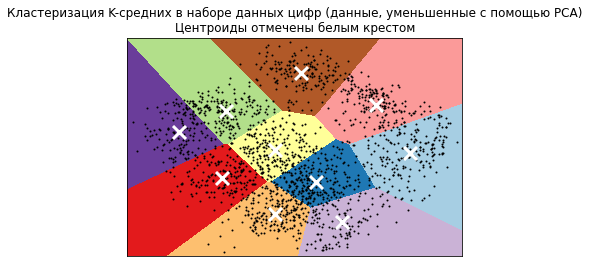

In [ ]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Размер шага сетки. Уменьшите, чтобы повысить качество VQ.
h = 0.02  # точка в сетке [x_min, x_max]x[y_min, y_max].

# Постройте границу решения. Для этого мы назначим цвет каждому
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Получите метки для каждой точки сетки. Используйте последнюю обученную модель.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Поместите результат в цветной график
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Постройте центроиды как белый X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "Кластеризация K-средних в наборе данных цифр (данные, уменьшенные с помощью PCA)\n"
    "Центроиды отмечены белым крестом"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
